In [256]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import optimize as opt

## Two dimensional example
Based on figure 1 in Sussillo and Barak 2013. Aim is to generate a simple 2D dyamical system and then use function q to find fixed and slow points which are candidates for linearization.

In [310]:
# Define a simple dynamical system with three fixed points
def F(x,t):
    x1, x2 = x
    
    x1d = (1-(x1**2)) * x2 
    x2d = (x1/2) - x2
    return [x1d,x2d]

In [311]:
# Now define function q to find fixed and slow points in the system F(x)
def q(x):
    t = 0 
    Fx = np.array(F(x,t))
    qx = (np.sum(abs(Fx)**2))/2
    return qx

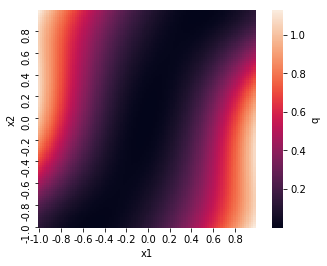

In [312]:
# calculate qx for every pair of x1 and x2
qx = np.zeros([100,100])
for i_ind, i in enumerate(np.linspace(-1,1,100)):
    for j_ind, j in enumerate(np.linspace(-1,1,100)):
        qx[i_ind, j_ind] = q(np.array([i,j]))

# plot heat map for values of q        
df = (pd.DataFrame(qx, 
      columns = np.round(np.linspace(-1,1,100),1),
      index = np.round(np.linspace(-1,1,100),1)))
ax = sns.heatmap(df, square=True, 
                 yticklabels=10, xticklabels=10,
                 cbar_kws={'label': 'q'})
ax.invert_yaxis()
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [322]:
# Find local minima in q to identify fixed and slow points
x0 = np.array([(-1,-1), (0,0), (1,1)]) # Sample a few initial conditions
minima = np.zeros([3,2])
for i, x in enumerate(x0):
    sol = opt.minimize(q, x, method='Nelder-Mead', tol=1e-6)
    minima[i,:] = sol.x
minima

array([[-0.99999968, -0.49999966],
       [ 0.        ,  0.        ],
       [ 0.99999968,  0.49999966]])

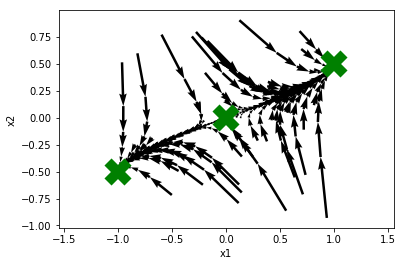

In [316]:
# randomly sample starting conditions between -1 and 1
x0 = [(-1 + 2*np.random.random(), -1 + 2*np.random.random()) 
      for i in range(50)]

# run the system from the various starting conditions 
# and plot trajectories
t = np.linspace(0,10,20)
plot = plt.figure()
for i, x in enumerate(x0):
    Fx = odeint(F, x, t)
    plt.quiver(Fx[:-1, 0], Fx[:-1, 1], # locations
               Fx[1:, 0]-Fx[:-1, 0], Fx[1:, 1]-Fx[:-1, 1], # values
               scale_units='xy', angles='xy', scale=1) 
    
# plot the minima we found for q - these are the fixed and slow points
plt.plot(minima[:,0], minima[:,1], "x", 
         markersize=20, markeredgewidth=10,
        markeredgecolor='g')
    
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('equal')

plt.show(plot)

## A simple RNN
Make and train a simple echostate RNN, then try to apply this analysis methods to it

### Making a simple rnn from scratch
Following equations and methods outlined in Sussillo and Barak, 2013,  and the review Sussillo, 2014.

In [431]:
class RNN:
    x = []
    r = []
    J = []
    B = []
    u = []
    Wfb = []
    z = []
    W = []
    
def create_rnn(x,J,B,u,Wfb,W,numcells,numinputs,numoutputs):
    rnn = RNN()
    rnn.numcells = numcells
    rnn.numinputs = numinputs
    rnn.numoutputs = numoutputs
    rnn.x = x
    rnn.r = np.tanh(x)
    rnn.J = J
    rnn.B = B
    rnn.u = u
    rnn.Wfb = Wfb
    rnn.W = W
    rnn.z = np.sum(rnn.W*np.transpose(np.matlib.repmat(rnn.r,rnn.numoutputs,1)),
               axis=0)
    return rnn

def rnn_update(network):
    # x is the activation of each neuron
    # J is the weight matrix of recurrent connections
    # B is the input weight matrix
    # u is the external inputs
    # b is a vector of biases for each cell
    # z is the output state, calculated using output weights W
    # which is fed back into the ntework by feedback weights Wfb
    # for each timestep:
    r = np.tanh(network.x)
    Jr = np.sum((network.J*r[:,None]),axis=0)
    Bu = np.sum(network.B*network.u, axis=1)
    Wfbz = np.sum(network.Wfb*network.z[None,:], axis=1)
    dx = -network.x + Jr + Wfbz + Bu
    z = np.sum(network.W*np.transpose(np.matlib.repmat(r,network.numoutputs,1)),
               axis=0)
    
    # now update the state of the network re: things that can change
    network.r = r
    network.z = z
    network.x = dx

In [432]:
# initialize the rnn
N = 1000 # number of neurons
Nu = 3 # number of input neurons
Nz = 3 # number of output neurons
x = np.random.random(N,)
J = -1 + 2*np.random.random([N,N])
B = -1 + 2*np.random.random([N,Nu])
u = np.array([0,0,0])
Wfb = -1 + 2*np.random.random([N,Nz])
W = -1 + 2*np.random.random([N,Nz])

network = create_rnn(x,J,B,u,Wfb,W,N,Nu,Nz)

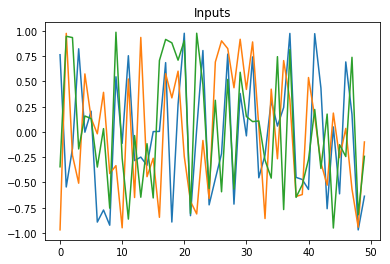

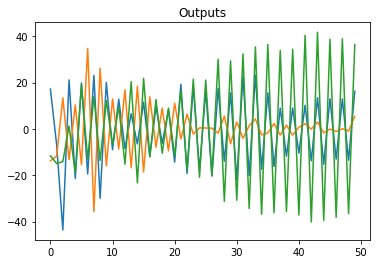

In [452]:
#re-initialzie rnn to "clean" state
network = create_rnn(x,J,B,u,Wfb,W,N,Nu,Nz)

# quickly test by giving the networks some inputs and plotting some outputs
t = np.arange(0,50)
# input random noise between -1 and 1
inputs = -1 + 2*np.random.random([3,50]) 
# initialzise holder for outputs
outputs = np.zeros([3,50])

for i in t:
    network.u = inputs[:,i]
    rnn_update(network)
    outputs[:,i] = network.z
    
plt.plot(np.transpose(inputs))
plt.title('Inputs')
plt.show()
plt.plot(np.transpose(outputs))
plt.title('Outputs')
plt.show()

Unsurpisingly, this highly connected network tends towards becomming very oscillatory